
TRAIN


In [59]:
import os
import cv2
import numpy as np
import pandas as pd
import string
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Conv2D, MaxPool2D, BatchNormalization, 
    Bidirectional, Activation, Reshape, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.activations import relu, sigmoid, softmax
import keras.backend as K

from datasets import load_dataset  # Để tải bộ dữ liệu từ Hugging Face Datasets


In [60]:
# Constants
char_list = list(
    "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    "ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝĂĐĨŨƠàáâãèéêìíòóôõùúýăđĩũơ"
    "ĂẮẰẲẴẶÂẤẦẨẪẬÊẾỀỂỄỆÔỐỒỔỖỘƠỚỜỞỠỢƯỨỪỬỮỰ"
    "àáâãèéêìíòóôõùúýăđĩũơăắằẳẵặâấầẩẫậêếềểễệ"
    "ôốồổỗộơớờởỡợưứừửữự"
)


max_label_len = 0

if isinstance(char_list, set):
    char_list = ''.join(sorted(char_list))

In [61]:

# Helper function to process image
def process_image(img):
    w, h = img.shape
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    if w < 32:
        add_zeros = np.full((32 - w, h), 255)
        img = np.concatenate((img, add_zeros))

    if h < 128:
        add_zeros = np.full((32, 128 - h), 255)
        img = np.concatenate((img, add_zeros), axis=1)

    img = cv2.resize(img, (128, 32))
    img = cv2.subtract(255, img)
    img = img.astype('float32') / 255

    return np.expand_dims(img, axis=2)

# Hàm encode_to_labels sửa lỗi
def encode_to_labels(txt):
    """Encodes each output word into digits based on char_list, dynamically updating it."""
    dig_lst = []
    global char_list  # Đảm bảo sử dụng char_list toàn cục
    for chara in txt:
        if chara not in char_list:
            char_list.append(chara)  # Thêm ký tự mới vào char_list
        dig_lst.append(char_list.index(chara))
    return dig_lst

In [62]:
# ==============================
# OLD DATASET (TXT File)
# ==============================
train_images, train_labels = [], []
valid_images, valid_labels = [], []
train_input_length, train_label_length = [], []
valid_input_length = []  # Fix: Initialize separately
valid_label_length = []  # Fix: Initialize separately

with open("F:/new data/words/words_new.txt") as f:
    contents = f.readlines()[19:22539]
lines = [line.strip() for line in contents]

for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]

    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        splits_id = word_id.split('-')
        filepath = f'F:/new data/words/iam_words/words/{splits_id[0]}/{splits_id[0]}-{splits_id[1]}/{word_id}.png'

        try:
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            img = process_image(img)
        except:
            continue

        try:
            label = encode_to_labels(word)
        except:
            continue

        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))

In [63]:
print("Số lượng ký tự trong char_list:", len(char_list))
print("Danh sách ký tự trong char_list:", char_list)


Số lượng ký tự trong char_list: 213
Danh sách ký tự trong char_list: ['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'À', 'Á', 'Â', 'Ã', 'È', 'É', 'Ê', 'Ì', 'Í', 'Ò', 'Ó', 'Ô', 'Õ', 'Ù', 'Ú', 'Ý', 'Ă', 'Đ', 'Ĩ', 'Ũ', 'Ơ', 'à', 'á', 'â', 'ã', 'è', 'é', 'ê', 'ì', 'í', 'ò', 'ó', 'ô', 'õ', 'ù', 'ú', 'ý', 'ă', 'đ', 'ĩ', 'ũ', 'ơ', 'Ă', 'Ắ', 'Ằ', 'Ẳ', 'Ẵ', 'Ặ', 'Â', 'Ấ', 'Ầ', 'Ẩ', 'Ẫ', 'Ậ', 'Ê', 'Ế', 'Ề', 'Ể', 'Ễ', 'Ệ', 'Ô', 'Ố', 'Ồ', 'Ổ', 'Ỗ', 'Ộ', 'Ơ', 'Ớ', 'Ờ', 'Ở', 'Ỡ', 'Ợ', 'Ư', 'Ứ', 'Ừ', 'Ử', 'Ữ', 'Ự', 'à', 'á', 'â', 'ã', 'è', 'é', 'ê', 'ì', 'í', 'ò', 'ó', 'ô', 'õ', 'ù', 'ú', 'ý', 'ă', 'đ', 'ĩ', 'ũ', 'ơ', 'ă', 'ắ', 'ằ', 'ẳ', 'ẵ', 'ặ', 'â', 'ấ', 'ầ', 

In [64]:

# ==============================
# NEW DATASET (Parquet File)
# ==============================
ds = load_dataset("DataStudio/OCR_handwritting_HAT2023")

processed_images = []
encoded_labels = []

for sample in ds['train']:
    # Process image
    img = np.array(sample['image'].convert('L'))  # Convert to grayscale
    img = process_image(img)
    
    # Process label
    try:
        label = encode_to_labels(sample['text'])  # Encode text to labels
        processed_images.append(img)
        encoded_labels.append(label)
    except Exception as e:
        print(f"Error processing text '{sample['text']}': {e}")



new_train_images, new_valid_images, new_train_labels, new_valid_labels = train_test_split(
    processed_images, encoded_labels, test_size=0.1, random_state=42
)

new_train_input_length = [31] * len(new_train_images)
new_valid_input_length = [31] * len(new_valid_images)
new_train_label_length = [len(label) for label in new_train_labels]
new_valid_label_length = [len(label) for label in new_valid_labels]

print("Số lượng ký tự trong char_list sau khi cập nhật:", len(char_list))
print("Danh sách ký tự trong char_list sau khi cập nhật:", "".join(char_list))


Số lượng ký tự trong char_list sau khi cập nhật: 243
Danh sách ký tự trong char_list sau khi cập nhật: !"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝĂĐĨŨƠàáâãèéêìíòóôõùúýăđĩũơĂẮẰẲẴẶÂẤẦẨẪẬÊẾỀỂỄỆÔỐỒỔỖỘƠỚỜỞỠỢƯỨỪỬỮỰàáâãèéêìíòóôõùúýăđĩũơăắằẳẵặâấầẩẫậêếềểễệôốồổỗộơớờởỡợưứừửữựẹỌạảủỎỤỊỉỦịỏẢụọẻẠẸỈẺẽỲỵẼỴỳỶỷỹỸ


In [65]:
import json
import pickle

# ==============================
# Lưu char_list vào file
# ==============================

# Phương pháp 1: Lưu char_list vào file JSON
json_path = "char_list.json"
with open(json_path, 'w') as f:
    json.dump(char_list, f)
print(f"char_list đã được lưu vào {json_path}")



char_list đã được lưu vào char_list.json


In [57]:

# ==============================
# Combine OLD and NEW Datasets
# ==============================
train_images.extend(new_train_images)
valid_images.extend(new_valid_images)

train_labels.extend(new_train_labels)
valid_labels.extend(new_valid_labels)

train_input_length.extend(new_train_input_length)
valid_input_length.extend(new_valid_input_length)

train_label_length.extend(new_train_label_length)
valid_label_length.extend(new_valid_label_length)

max_label_len = max(max([len(label) for label in train_labels], default=0),
                    max([len(label) for label in valid_labels], default=0))

# Padding labels
train_padded_label = pad_sequences(
    train_labels, maxlen=max_label_len, padding='post', value=len(char_list)
)
valid_padded_label = pad_sequences(
    valid_labels, maxlen=max_label_len, padding='post', value=len(char_list)
)

# Convert images to numpy arrays
train_images = np.asarray(train_images).reshape(-1, 32, 128, 1)
valid_images = np.asarray(valid_images).reshape(-1, 32, 128, 1)

# Save combined dataset
np.save("train_images_combined.npy", train_images)
np.save("train_labels_combined.npy", train_padded_label)
np.save("valid_images_combined.npy", valid_images)
np.save("valid_labels_combined.npy", valid_padded_label)

# Summary
print(f"Total train images: {len(train_images)}, Total train labels: {len(train_padded_label)}")
print(f"Total valid images: {len(valid_images)}, Total valid labels: {len(valid_padded_label)}")
print(f"Max label length: {max_label_len}")

Total train images: 110842, Total train labels: 110842
Total valid images: 12304, Total valid labels: 12304
Max label length: 17


In [30]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

In [31]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, LSTM, Bidirectional, Dense, Input, Reshape, Dropout, Concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from keras.layers import SpatialDropout2D

def Model1():
    inputs = Input(shape=(32, 128, 1))  # Input shape: (height, width, channel)

    # Lớp CNN đầu tiên
    conv_1 = Conv2D(128, (5, 5), activation='relu', padding='same')(inputs)  # Tăng số bộ lọc lên 128
    batch_norm_1 = BatchNormalization()(conv_1)
    pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(batch_norm_1)
    dropout_1 = SpatialDropout2D(0.2)(pool_1)  # Tăng SpatialDropout2D lên 0.3

    # Lớp CNN thứ hai
    conv_2a = Conv2D(256, (3, 3), activation='relu', padding='same')(dropout_1)  # Tăng số bộ lọc lên 256
    conv_2b = Conv2D(256, (5, 5), activation='relu', padding='same')(dropout_1)  # Lớp song song với kích thước bộ lọc khác
    concat_2 = Concatenate()([conv_2a, conv_2b])
    batch_norm_2 = BatchNormalization()(concat_2)
    pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(batch_norm_2)
    dropout_2 = SpatialDropout2D(0.2)(pool_2)  # SpatialDropout2D

    # Lớp CNN thứ ba và thứ tư
    conv_3a = Conv2D(512, (3, 3), activation='relu', padding='same')(dropout_2)  # Tăng số bộ lọc lên 512
    conv_3b = Conv2D(512, (5, 5), activation='relu', padding='same')(dropout_2)  # Lớp song song với kích thước bộ lọc khác
    concat_3 = Concatenate()([conv_3a, conv_3b])
    batch_norm_3 = BatchNormalization()(concat_3)

    conv_4 = Conv2D(512, (3, 3), activation='relu', padding='same')(batch_norm_3)
    batch_norm_4 = BatchNormalization()(conv_4)
    pool_4 = MaxPool2D(pool_size=(2, 1))(batch_norm_4)
    dropout_4 = SpatialDropout2D(0.2)(pool_4)  # Tăng SpatialDropout2D lên 0.4

    # Lớp CNN thứ năm và thứ sáu
    conv_5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(dropout_4)  # Tăng số bộ lọc lên 1024
    conv_5b = Conv2D(1024, (5, 5), activation='relu', padding='same')(dropout_4)  # Lớp song song với kích thước bộ lọc khác
    concat_5 = Concatenate()([conv_5a, conv_5b])
    batch_norm_5 = BatchNormalization()(concat_5)

    conv_6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    dropout_6 = SpatialDropout2D(0.3)(pool_6)  # SpatialDropout2D

    # Lớp CNN cuối cùng
    conv_7 = Conv2D(2048, (2, 2), activation='relu')(dropout_6)  # Tăng số bộ lọc lên 2048
    batch_norm_7 = BatchNormalization()(conv_7)

     # Định hình lại đầu ra CNN
    reshaped = Reshape((31, 2048))(batch_norm_7)  # Thay đổi để phù hợp với số bộ lọc tăng lên
    
    # Lớp LSTM
    blstm_1 = Bidirectional(LSTM(512, return_sequences=True, dropout=0.2))(reshaped)  # Tăng số tế bào LSTM lên 512
    blstm_2 = Bidirectional(LSTM(512, return_sequences=True, dropout=0.3))(blstm_1)  
    blstm_3 = Bidirectional(LSTM(512, return_sequences=True, dropout=0.4))(blstm_2)  

    # Lớp Dense
    dense = Dense(1024, activation='relu')(blstm_3)  # Tăng số đơn vị trong Dense lên 1024
    batch_norm_dense = BatchNormalization()(dense)
    dense_dropout = Dropout(0.4)(batch_norm_dense)  # Tăng Dropout lên 0.4
    outputs = Dense(len(char_list) + 1, activation='softmax')(dense_dropout)

    act_model = Model(inputs, outputs)
    
    return act_model, outputs, inputs


In [32]:
act_model,outputs,inputs=Model1()

act_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 128, 128  3328        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 128, 128  512        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [33]:
# ==============================
# CTC LOSS FUNCTION FOR TRAINING
# ==============================
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # y_pred: output từ mô hình (batch_size, time_steps, num_classes)
    # labels: ground truth text đã encode thành số
    # input_length: độ dài sequence sau CNN-BiLSTM
    # label_length: độ dài thực tế của text
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD
RECORDS_COUNT = 30000
batch_size = 128
epochs = 150
e = str(epochs)
optimizer_name = 'Adam'
# optimizer_name = 'SGD'

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="./hdf5s/{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))



In [13]:
import numpy as np

# Chuyển đổi các danh sách sang numpy.ndarray
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

# Kiểm tra lại hình dạng (shape)
print("train_images shape:", train_images.shape)
print("train_padded_label shape:", train_padded_label.shape)
print("train_input_length shape:", train_input_length.shape)
print("train_label_length shape:", train_label_length.shape)

print("valid_images shape:", valid_images.shape)
print("valid_padded_label shape:", valid_padded_label.shape)
print("valid_input_length shape:", valid_input_length.shape)
print("valid_label_length shape:", valid_label_length.shape)


train_images shape: (110842, 32, 128, 1)
train_padded_label shape: (110842, 17)
train_input_length shape: (110842,)
train_label_length shape: (110842,)
valid_images shape: (12304, 32, 128, 1)
valid_padded_label shape: (12304, 17)
valid_input_length shape: (12304,)
valid_label_length shape: (12304,)


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Callback ModelCheckpoint 
checkpoint = ModelCheckpoint(
    filepath=filepath, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

# Callback ReduceLROnPlateau 
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.5,  
    patience=5,  
    min_lr=1e-6, 
    verbose=1
)

# Callback EarlyStopping 
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=2,  
    restore_best_weights=True, 
    verbose=10
)

# Danh sách callback
callbacks_list = [checkpoint, reduce_lr, early_stopping]

history = model.fit(
    x=[train_images, train_padded_label, train_input_length, train_label_length],
    y=np.zeros(len(train_images)),  # Dummy y
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(
        [valid_images, valid_padded_label, valid_input_length, valid_label_length],
        np.zeros(len(valid_images))  # Dummy validation y
    ),
    verbose=1,
    callbacks=callbacks_list,
)



Epoch 1/150
866/866 [==============================] - ETA: 0s - loss: 18.6919 - accuracy: 9.0219e-06
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to ./hdf5s\Adamo-30000r-150e-110842t-12304v.hdf5
866/866 [==============================] - 919s 978ms/step - loss: 18.6919 - accuracy: 9.0219e-06 - val_loss: 16.0869 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/150
866/866 [==============================] - ETA: 0s - loss: 13.4851 - accuracy: 0.0021
Epoch 2: val_accuracy improved from 0.00000 to 0.00805, saving model to ./hdf5s\Adamo-30000r-150e-110842t-12304v.hdf5
866/866 [==============================] - 785s 906ms/step - loss: 13.4851 - accuracy: 0.0021 - val_loss: 11.8300 - val_accuracy: 0.0080 - lr: 0.0010
Epoch 3/150
866/866 [==============================] - ETA: 0s - loss: 8.6094 - accuracy: 0.0143
Epoch 3: val_accuracy improved from 0.00805 to 0.03885, saving model to ./hdf5s\Adamo-30000r-150e-110842t-12304v.hdf5
866/866 [==============================] - 7

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Lấy dữ liệu loss và accuracy từ lịch sử huấn luyện
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    accuracy = history.history.get('accuracy')
    val_accuracy = history.history.get('val_accuracy')
    
    epochs = range(1, len(loss) + 1)

    # Vẽ đồ thị Loss
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Vẽ đồ thị Accuracy
    plt.subplot(1, 2, 2)
    if accuracy:
        plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    if val_accuracy:
        plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [35]:
# load CRNN Model
filepath="./hdf5s/{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))
# filepath='F:/AI/CRNN VN/Adamo-30000r-200e-18074t-2007v.hdf5'
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)


385/385 [==============================] - 37s 77ms/step


In [ ]:
# import h5py

# def save_history_to_hdf5(history, filename):
#     # Tạo một file HDF5 mới
#     with h5py.File(filename, 'w') as f:
#         # Lưu các giá trị loss và accuracy
#         f.create_dataset('loss', data=history.history['loss'])
#         if 'val_loss' in history.history:
#             f.create_dataset('val_loss', data=history.history['val_loss'])
#         if 'accuracy' in history.history:
#             f.create_dataset('accuracy', data=history.history['accuracy'])
#         if 'val_accuracy' in history.history:
#             f.create_dataset('val_accuracy', data=history.history['val_accuracy'])

# # Lưu lịch sử huấn luyện vào file 'training_history.h5'
# save_history_to_hdf5(history, 'training_history.h5')


In [ ]:
# def load_history_from_hdf5(filename):
#     # Mở file HDF5 và tải các dữ liệu
#     with h5py.File(filename, 'r') as f:
#         history = {
#             'loss': list(f['loss']),
#             'val_loss': list(f['val_loss']) if 'val_loss' in f else None,
#             'accuracy': list(f['accuracy']) if 'accuracy' in f else None,
#             'val_accuracy': list(f['val_accuracy']) if 'val_accuracy' in f else None
#         }
#     return history

# # Tải lịch sử huấn luyện từ file 'training_history.h5'
# history = load_history_from_hdf5('training_history.h5')

# # Vẽ lại đồ thị với dữ liệu đã tải
# plot_training_history(history)


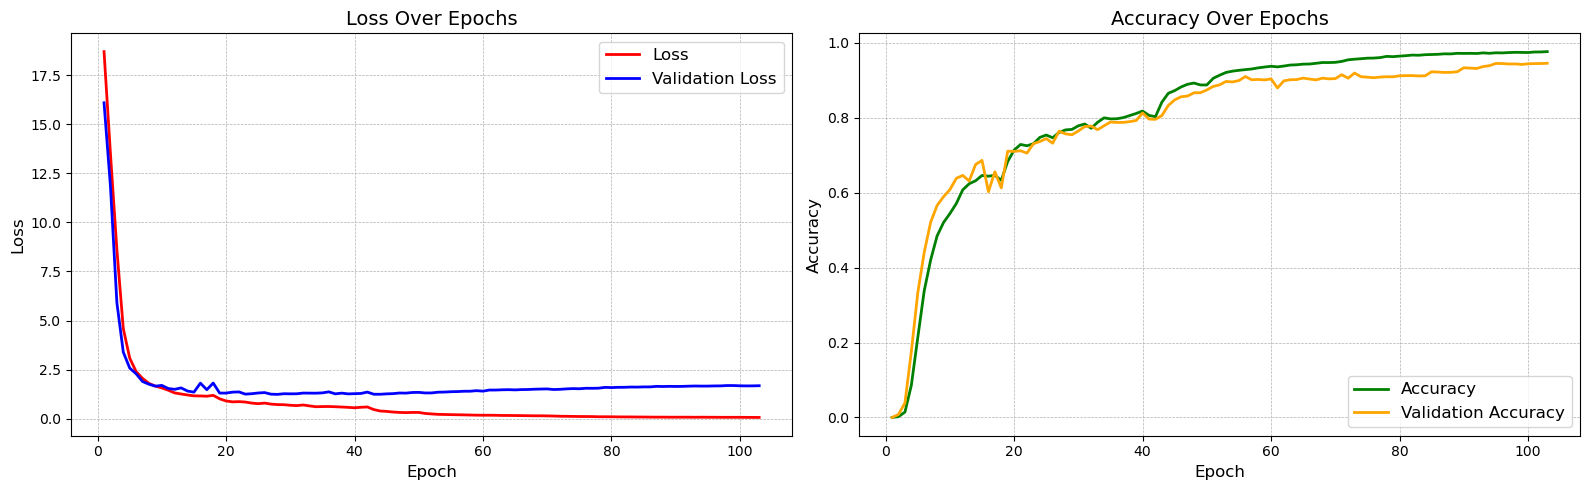

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file Excel
def read_data_from_excel(file_path):
    df = pd.read_excel(file_path, engine='openpyxl')
    return df

# Hàm vẽ đồ thị Loss
def plot_loss_graph(ax, df):
    ax.plot(df['Epoch'], df['Loss'], label='Loss', color='red', linestyle='-', linewidth=2)
    ax.plot(df['Epoch'], df['Val_Loss'], label='Validation Loss', color='blue', linestyle='-', linewidth=2)
    
    # Thiết lập tiêu đề và nhãn trục
    ax.set_title('Loss Over Epochs', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    
    # Thêm legend và grid
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Hàm vẽ đồ thị Accuracy
def plot_accuracy_graph(ax, df):
    ax.plot(df['Epoch'], df['Accuracy'], label='Accuracy', color='green', linestyle='-', linewidth=2)
    ax.plot(df['Epoch'], df['Val_Accuracy'], label='Validation Accuracy', color='orange', linestyle='-', linewidth=2)
    
    # Thiết lập tiêu đề và nhãn trục
    ax.set_title('Accuracy Over Epochs', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    
    # Thêm legend và grid
    ax.legend(loc='lower right', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Đọc dữ liệu từ file Excel
file_path = "F:/epoch_results.xlsx"  # Đường dẫn file Excel của bạn
df = read_data_from_excel(file_path)

# Tạo hình và các subplots (2 đồ thị con)
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # Tạo 2 hàng, 1 cột

# Vẽ đồ thị Loss trên subplot đầu tiên
plot_loss_graph(axs[0], df)

# Vẽ đồ thị Accuracy trên subplot thứ hai
plot_accuracy_graph(axs[1], df)

# Tinh chỉnh layout để tránh chồng lấn
plt.tight_layout()

# Hiển thị đồ thị
plt.show()


In [37]:
# b04-034_handwritten_text.png
# a04-027_handwritten_text.png
# a01-000x_handwritten_text.png
# a01-091_handwritten_text.png
# a02-012_handwritten_text.png

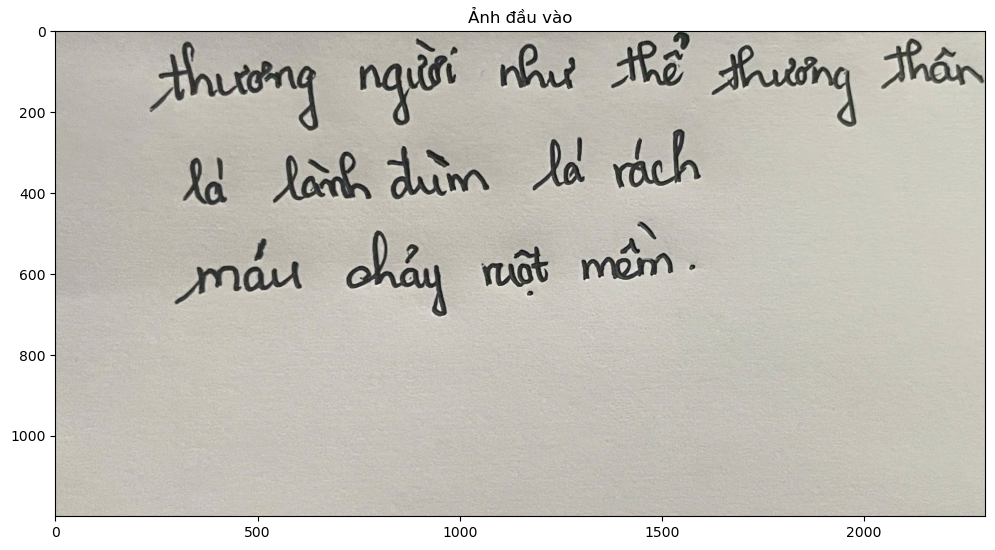

In [38]:
# %% [markdown]
# ### Bước 1: Gắn đường dẫn ảnh đầu vào và hiển thị ảnh
import cv2
import numpy as np
import matplotlib.pyplot as plt
image_path = 'F:/AI/CRNN VN/z6085526610955_5490c9ee339bf0efa3b8c6863415fd6f.jpg' 
# image_path = 'F:/AI/CRNN VN/viet-tay-4-1342522969.jpg'  
# image_path = 'F:/AI/final/a02-008_handwritten_text.png'  
# image_path = 'F:/AI/vn_handwritten_images/data/0106_samples.png'  
image = cv2.imread(image_path)

# Cắt ảnh để tập trung vào khu vực chứa chữ (giúp giảm nhiễu từ các vùng không liên quan)
image = image[00:1200, 
              00:2300]

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Ảnh đầu vào')
plt.show()

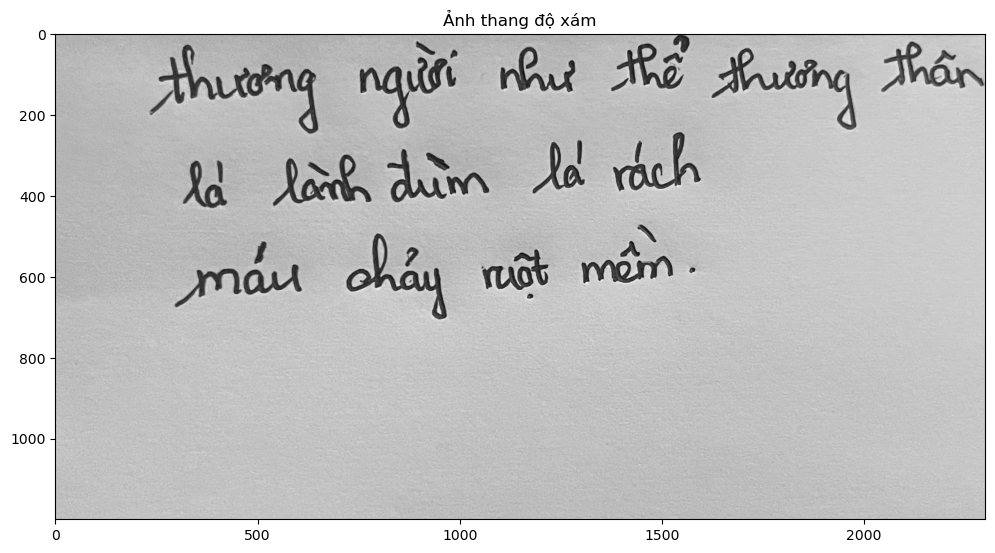

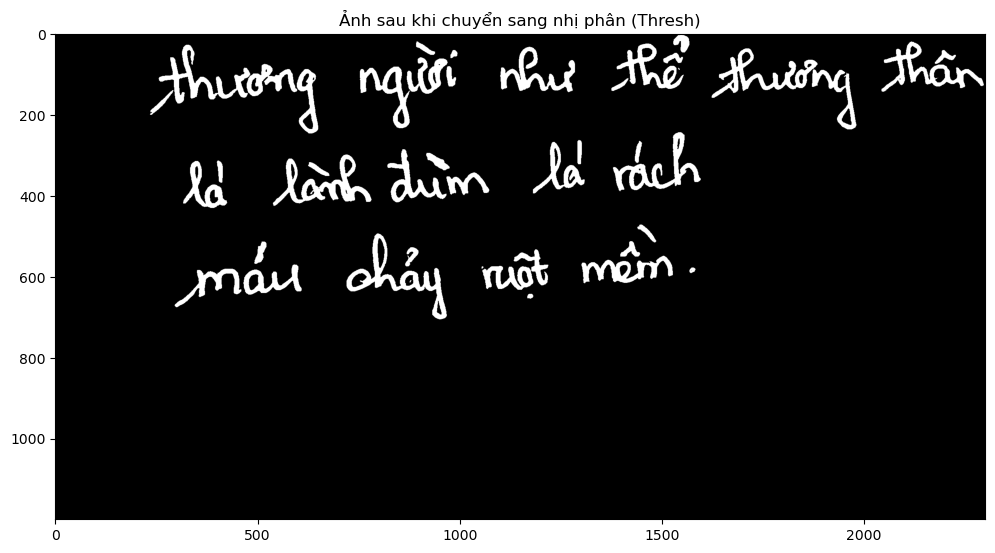

In [39]:
# %% [markdown]
# ### Bước 2: Chuyển ảnh sang thang độ xám
if len(image.shape) == 3:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else:
    gray = image

plt.figure(figsize=(12, 8))
plt.imshow(gray, cmap='gray')
plt.title('Ảnh thang độ xám')
plt.show()
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.figure(figsize=(12, 8))
plt.imshow(thresh, cmap='gray')
plt.title('Ảnh sau khi chuyển sang nhị phân (Thresh)')
plt.show()


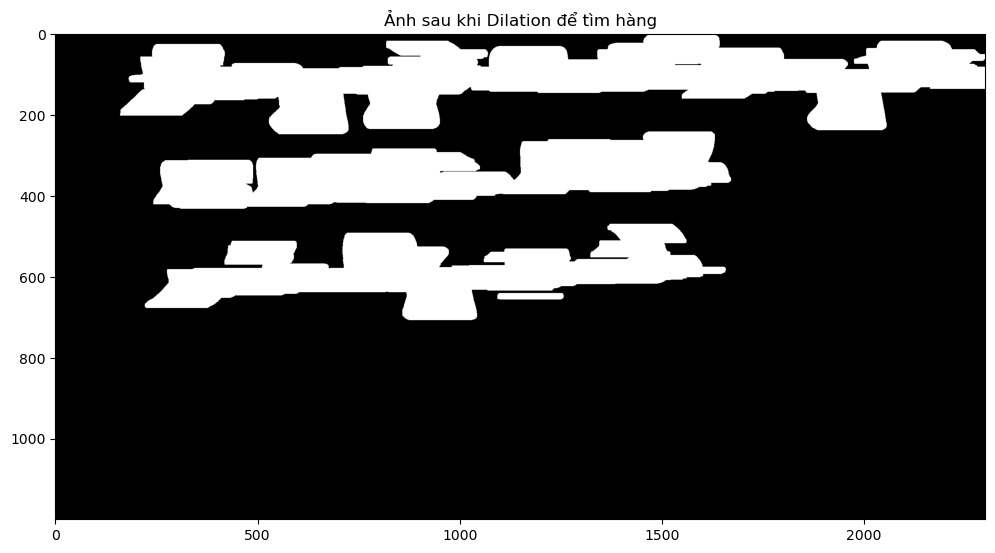

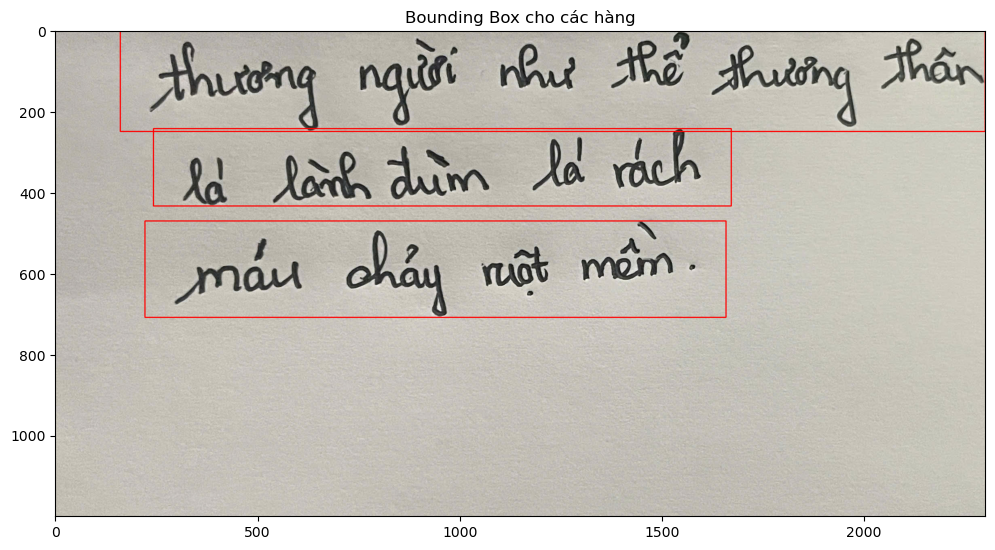

In [40]:

# %% [markdown]
# ### Bước 4: Tạo Bounding Box cho các hàng
# Dilation để làm nổi bật vùng chứa hàng
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

kernel = np.ones((5, 150), np.uint8)  # Tăng kích thước kernel để gộp các hàng lại với nhau  # Giảm kích thước kernel để tránh việc tách các dấu nhỏ thành hàng riêng
img_dilation = cv2.dilate(thresh, kernel, iterations=1)
plt.figure(figsize=(12, 8))
plt.imshow(img_dilation, cmap='gray')
plt.title('Ảnh sau khi Dilation để tìm hàng')
plt.show()

# Tìm các contours để phát hiện các hàng
contours, _ = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rows = []
for ctr in contours:
    x, y, w, h = cv2.boundingRect(ctr)
    if h > 30:  # Tăng giá trị chiều cao để loại bỏ các contour nhiễu
        row = gray[y:y + h, x:x + w]
        rows.append((x, y, w, h, row))

# Sắp xếp các hàng theo thứ tự từ trên xuống
rows = sorted(rows, key=lambda r: r[1])

# Ghép các contour nhỏ (ví dụ: dấu ngoặc kép) với hàng gần nhất
merged_rows = []
for i in range(len(rows)):
    if i > 0 and rows[i][3] < 20:  # Nếu chiều cao của contour nhỏ (ví dụ: dấu ngoặc kép)
        # Ghép vào hàng trước đó
        prev_x, prev_y, prev_w, prev_h, prev_row = merged_rows[-1]
        new_x = min(prev_x, rows[i][0])
        new_y = min(prev_y, rows[i][1])
        new_w = max(prev_x + prev_w, rows[i][0] + rows[i][2]) - new_x
        new_h = max(prev_y + prev_h, rows[i][1] + rows[i][3]) - new_y
        new_row = gray[new_y:new_y + new_h, new_x:new_x + new_w]
        merged_rows[-1] = (new_x, new_y, new_w, new_h, new_row)
    else:
        merged_rows.append(rows[i])
rows = merged_rows

# Đảm bảo không có hàng bị trùng lặp hoặc thêm sai
rows = sorted(rows, key=lambda r: r[1])

# Sắp xếp các hàng theo thứ tự từ trên xuống
rows = sorted(rows, key=lambda r: r[1])

# Vẽ bounding box các hàng lên ảnh gốc
image_rows = image.copy()
for (x, y, w, h, _) in rows:
    cv2.rectangle(image_rows, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Sử dụng màu đỏ để phân biệt

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image_rows, cv2.COLOR_BGR2RGB))
plt.title('Bounding Box cho các hàng')
plt.show()

# # Hiển thị từng hàng đã được cắt
# for idx, (x, y, w, h, row) in enumerate(rows):
#     plt.figure(figsize=(12, 4))
#     plt.imshow(row, cmap='gray')
#     plt.title(f'Hàng {idx + 1}')
#     plt.show()


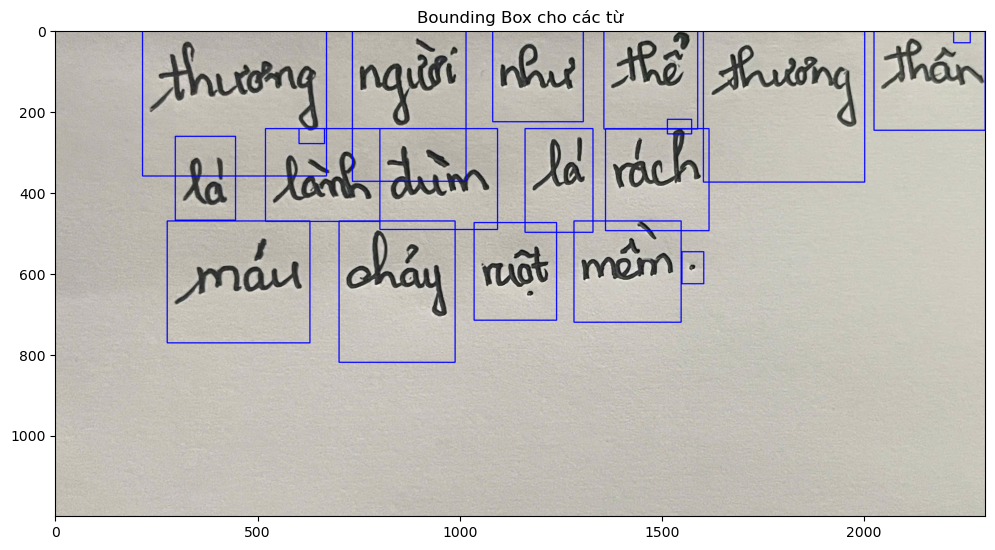

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Giả sử biến image là hình ảnh gốc và rows là danh sách các hàng văn bản đã được xác định trước đó
image_words = image.copy()
rows = sorted(rows, key=lambda r: r[1])  # Sắp xếp các hàng theo thứ tự từ trên xuống
words_in_rows = []

# Hệ số điều chỉnh chiều cao
height_scale = 1.5  # Có thể thay đổi tùy theo yêu cầu

for (x, y, w, h, row) in rows:
    # Tạo kernel để làm giãn các vùng chứa từ
    kernel_word = np.ones((40, 40), np.uint8)
    row_thresh = cv2.threshold(row, 127, 255, cv2.THRESH_BINARY_INV)[1]
    row_dilation = cv2.dilate(row_thresh, kernel_word, iterations=1)
    
    # Tìm các contours của từ
    word_contours, _ = cv2.findContours(row_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    word_contours = sorted(word_contours, key=lambda ctr: cv2.boundingRect(ctr)[0])  # Sắp xếp từ trái sang phải
    words = []
    for ctr in word_contours:
        wx, wy, ww, wh = cv2.boundingRect(ctr)
        
        # Kiểm tra ngưỡng kích thước để loại bỏ nhiễu
        if ww > 15 and wh > 15:
            # Tinh chỉnh chiều cao bounding box
            new_wh = int(wh * height_scale)
            wy_adjusted = max(0, wy - (new_wh - wh) // 2)  # Đảm bảo không vượt quá hình ảnh
            
            # Cắt từ dựa trên bounding box đã điều chỉnh
            word = row[wy_adjusted:wy_adjusted + new_wh, wx:wx + ww]
            words.append((x + wx, y + wy_adjusted, ww, new_wh, word))
            
            # Vẽ bounding box lên ảnh gốc
            cv2.rectangle(image_words, (x + wx, y + wy_adjusted), (x + wx + ww, y + wy_adjusted + new_wh), (255, 0, 0), 2)
    
    words_in_rows.append(words)

# Hiển thị hình ảnh với các bounding box
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image_words, cv2.COLOR_BGR2RGB))
plt.title('Bounding Box cho các từ')
plt.show()


1/1 [==============================] - 0s 40ms/step
Dòng dự đoán (hàng 1): thương người như thể . thương thăn .


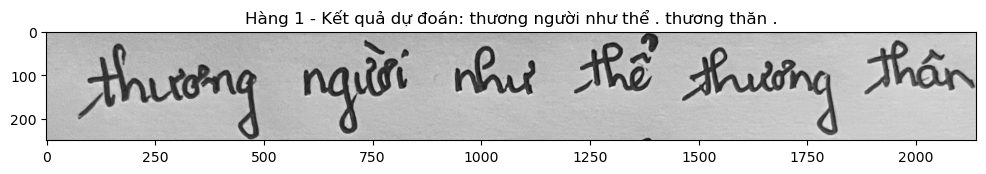

1/1 [==============================] - 0s 45ms/step
Dòng dự đoán (hàng 2): lá lành .ĩ đùm lá rách


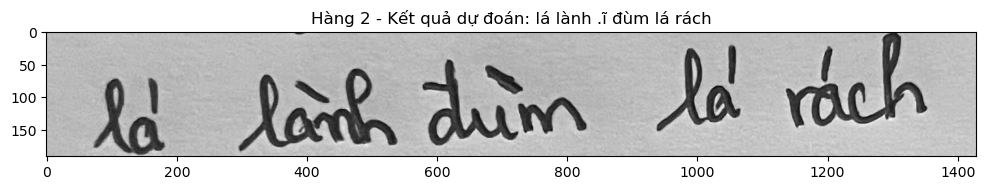

1/1 [==============================] - 0s 42ms/step
Dòng dự đoán (hàng 3): máu chảy nột mầm .


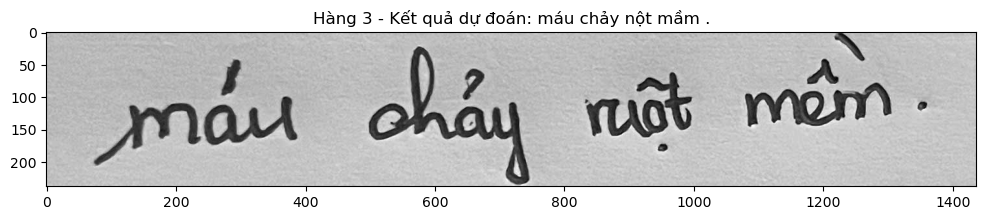


Văn bản đầy đủ dự đoán:
thương người như thể . thương thăn .
lá lành .ĩ đùm lá rách
máu chảy nột mầm .



In [42]:

# %% [markdown]
# ### Bước 6: Nhận diện các từ từ các hàng và hiển thị kết quả
def recognize_text(model, word_img, char_list):
    # Tiền xử lý ảnh (nếu cần)
    word_img = process_image(word_img)  # Gọi hàm xử lý ảnh nếu có
    word_img = np.expand_dims(word_img, axis=0)  # Thêm batch dimension cho ảnh

    # Dự đoán
    prediction = model.predict(word_img)
    
    # Giải mã CTC để chuyển từ dạng số sang văn bản
    decoded = K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1], greedy=True)[0][0]
    out = K.get_value(decoded)

    # Chuyển kết quả thành chuỗi văn bản
    text = ''.join([char_list[int(p)] for p in out[0] if int(p) != -1])
    
    return text

full_text = ""
rows = sorted(rows, key=lambda r: r[1])  # Sắp xếp lại các hàng theo thứ tự từ trên xuống và đảm bảo không có trùng lặp
words_in_rows = words_in_rows[:len(rows)]  # Đảm bảo số lượng từ phù hợp với số lượng hàng

for row_idx, words in enumerate(words_in_rows):
    row_text = ""
    for (wx, wy, ww, wh, word_img) in words:
        predicted_char = recognize_text(act_model, word_img, char_list)
        row_text += predicted_char + " "
    full_text += row_text.strip() + "\n"
    print(f"Dòng dự đoán (hàng {row_idx + 1}): {row_text.strip()}")
    
    # Hiển thị kết quả của từng hàng và so sánh với ảnh gốc
    if row_idx < len(rows):  # Kiểm tra để tránh lỗi vượt quá chỉ số
        plt.figure(figsize=(12, 4))
        plt.imshow(rows[row_idx][4], cmap='gray')
    plt.title(f'Hàng {row_idx + 1} - Kết quả dự đoán: {row_text.strip()}' )
    plt.show()

print("\nVăn bản đầy đủ dự đoán:")
print(full_text)

In [43]:
# import pyttsx3
# def text_to_speech(text):
#     engine = pyttsx3.init()
#     engine.setProperty('rate', 125) 
#     voices = engine.getProperty('voices')
#     engine.setProperty('voice', voices[0].id)  
#     engine.say(text)
#     engine.runAndWait()

# # Chuyển văn bản dự đoán thành giọng nói
# text_to_speech(full_text)


In [ ]:
# from tensorflow.keras import layers
# from tensorflow.keras import Model
# from tensorflow.keras import backend as tf_keras_backend
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

# tf_keras_backend.set_image_data_format('channels_last')
# tf_keras_backend.image_data_format()
# from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, LSTM, Bidirectional, Dense, Input, Reshape, Dropout, Concatenate
# from tensorflow.keras.models import Model
# import tensorflow.keras.backend as K
# from keras.layers import SpatialDropout2D

# def Model1():
#     inputs = Input(shape=(32, 128, 1))  # Input shape: (height, width, channel)

#     # Lớp CNN đầu tiên
#     conv_1 = Conv2D(128, (5, 5), activation='relu', padding='same')(inputs)  # Tăng số bộ lọc lên 128
#     batch_norm_1 = BatchNormalization()(conv_1)
#     pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(batch_norm_1)
#     dropout_1 = SpatialDropout2D(0.3)(pool_1)  # Tăng SpatialDropout2D lên 0.3

#     # Lớp CNN thứ hai
#     conv_2a = Conv2D(256, (3, 3), activation='relu', padding='same')(dropout_1)  # Tăng số bộ lọc lên 256
#     conv_2b = Conv2D(256, (5, 5), activation='relu', padding='same')(dropout_1)  # Lớp song song với kích thước bộ lọc khác
#     concat_2 = Concatenate()([conv_2a, conv_2b])
#     batch_norm_2 = BatchNormalization()(concat_2)
#     pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(batch_norm_2)
#     dropout_2 = SpatialDropout2D(0.3)(pool_2)  # SpatialDropout2D

#     # Lớp CNN thứ ba và thứ tư
#     conv_3a = Conv2D(512, (3, 3), activation='relu', padding='same')(dropout_2)  # Tăng số bộ lọc lên 512
#     conv_3b = Conv2D(512, (5, 5), activation='relu', padding='same')(dropout_2)  # Lớp song song với kích thước bộ lọc khác
#     concat_3 = Concatenate()([conv_3a, conv_3b])
#     batch_norm_3 = BatchNormalization()(concat_3)

#     conv_4 = Conv2D(512, (3, 3), activation='relu', padding='same')(batch_norm_3)
#     batch_norm_4 = BatchNormalization()(conv_4)
#     pool_4 = MaxPool2D(pool_size=(2, 1))(batch_norm_4)
#     dropout_4 = SpatialDropout2D(0.4)(pool_4)  # Tăng SpatialDropout2D lên 0.4

#     # Lớp CNN thứ năm và thứ sáu
#     conv_5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(dropout_4)  # Tăng số bộ lọc lên 1024
#     conv_5b = Conv2D(1024, (5, 5), activation='relu', padding='same')(dropout_4)  # Lớp song song với kích thước bộ lọc khác
#     concat_5 = Concatenate()([conv_5a, conv_5b])
#     batch_norm_5 = BatchNormalization()(concat_5)

#     conv_6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(batch_norm_5)
#     batch_norm_6 = BatchNormalization()(conv_6)
#     pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
#     dropout_6 = SpatialDropout2D(0.4)(pool_6)  # SpatialDropout2D

#     # Lớp CNN cuối cùng
#     conv_7 = Conv2D(2048, (2, 2), activation='relu')(dropout_6)  # Tăng số bộ lọc lên 2048
#     batch_norm_7 = BatchNormalization()(conv_7)

#     # Định hình lại đầu ra CNN
#     reshaped = Reshape((31, 2048))(batch_norm_7)  # Thay đổi để phù hợp với số bộ lọc tăng lên
    
#     # Lớp LSTM
#     blstm_1 = Bidirectional(LSTM(512, return_sequences=True, dropout=0.2))(reshaped)  # Tăng số tế bào LSTM lên 512
#     blstm_2 = Bidirectional(LSTM(512, return_sequences=True, dropout=0.3))(blstm_1)  
#     blstm_3 = Bidirectional(LSTM(512, return_sequences=True, dropout=0.4))(blstm_2)  

#     # Lớp Dense
#     dense = Dense(1024, activation='relu')(blstm_3)  # Tăng số đơn vị trong Dense lên 1024
#     batch_norm_dense = BatchNormalization()(dense)
#     dense_dropout = Dropout(0.4)(batch_norm_dense)  # Tăng Dropout lên 0.4
#     outputs = Dense(len(char_list) + 1, activation='softmax')(dense_dropout)

#     act_model = Model(inputs, outputs)
    
#     return act_model, outputs, inputs
